This notebook helps you to explore my solution submitted for SpaceNet5. The SpaceNet5 involved the process of extracting huge dataset from S3 followed creating our own training masks with geojson and many more steps in a month long journey which I'm planning to put up as a post shortly. Meanwhile, you can play with test dataset, model and have fun /mock my solution. 

Kindly download required files from the drive link in notebook. Running this notebook in colab is advisable. Else make sure install all libraries in import section

In [22]:
'''
if working on colab
'''
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
### browse below files here https://drive.google.com/drive/folders/1BjJLiADNFg7rzSFWq1z-fO-Sd23ieVs4?usp=sharing ###
'''
!tar xzf "/content/drive/My Drive/spacenet/testset/SN5_roads_test_public_AOI_8_Mumbai.tar.gz"
!tar xzf "/content/drive/My Drive/spacenet/testset/SN5_roads_test_public_AOI_7_Moscow.tar.gz"
!tar xzf "/content/drive/My Drive/spacenet/testset/SN5_roads_test_public_AOI_9_San_Juan.tar.gz"

!cp -r  '/content/drive/My Drive/spacenet/inference/pipeline' '/content'
!cp  '/content/drive/My Drive/spacenet/inference/config.py' '/content' '''
!cp  '/content/drive/My Drive/spacenet/inference/submission_utils.py' '/content'
!cp  '/content/drive/My Drive/spacenet/inference/viewer.py' '/content'

In [0]:
!mkdir cache
!mkdir input 
!mkdir model
!mkdir csv
!mkdir csv/dir_csv

In [5]:
!pip install segmentation_models==1.0.0
!pip install sknw
!pip install shapely
!pip install networkx==2.3

  Created wheel for sknw: filename=sknw-0.13-cp36-none-any.whl size=5100 sha256=184b76b12b6327287c2d7b38b4cb09cf1950254471dbc45f60596e68835f4f88
  Stored in directory: /root/.cache/pip/wheels/bd/f1/6e/624c021bb2e2c5e46a890017ab695d17c4d01c0b7ed1e353fc
Successfully built sknw
     |████████████████████████████████| 1.8MB 2.7MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=5119f8356f8ee81a7404dc915948a77e1d3b9c644559870942f7a21ce820b9e8
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.4
    Uninstalling networkx-2.4:
      Successfully uninstalled networkx-2.4


In [1]:
 %tensorflow_version 1.x magic
 ## Yes we are moving to age of TF2.0 shortly
from pipeline.load_model import load_model
from pipeline.mask2lstr_v1 import mask2linestring
from pipeline.utils import process_img,process_path
from submission_utils import *
from config import IMG_PATH,IMG_DIR,MODEL_PATH,IMG_SIZE,WRITE_TO_CSV
from glob import glob
from skimage.morphology import opening,closing,disk
from shapely.geometry import LineString
from shutil import *
import os
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x magic`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
### distance to choose the nearest neighbour
thresh=10
speeds=[0,6.7056,8.3820,8.9408,10.0584,11.1760,13.4112,15.6464,20.1168,24.5872,29.0576]
start_channel=1

In [3]:
#### load model to memory along with custom objects in pipeline.load_model ####
MODEL_PATH='/content/drive/My Drive/spacenet/csvandh5/version3_efficientnetb4_(512, 512, 3)_ALLCLASSES_0.6185628585901457_0.6314565579404511_seed_7_epoch_40.h5'
model=load_model(MODEL_PATH)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [18]:
### flush files in input dirs ###
[os.remove(f) for f in glob('/content/input/*')]
[os.remove(f) for f in glob('/content/csv/dir_csv/*')]

### choose file replace your path ###
dir_path='/content/nfs/data/cosmiq/spacenet/competitions/SN5_roads/tiles_upload/test_public/AOI_8_Mumbai/PS-RGB/'
dir_files=sorted(glob(dir_path+'*'))
randn=np.random.randint(0,len(dir_files))
### select random path ###
rand_path=dir_files[randn]

#### move random file to 'content/input' ####
path=copy(rand_path,'/content/input')
print(path)

/content/input/SN5_roads_test_public_AOI_8_Mumbai_PS-RGB_chip129.tif


  0%|          | 0/1 [00:00<?, ?it/s]

True
/content/input/SN5_roads_test_public_AOI_8_Mumbai_PS-RGB_chip129.tif


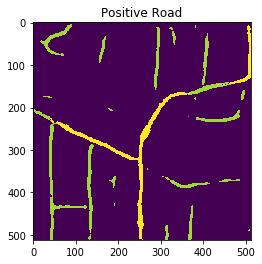

100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

csv file saved to dir_csv/8_Mumbai_129_10.csv


In [19]:
### create linestring csv for extracted roads from input image
if os.path.exists(path):
  csv_path=submit_dir('/content/input',model,thresh,0.5,start_channel,speeds)
else:
  print('File Error: Check Input directory')

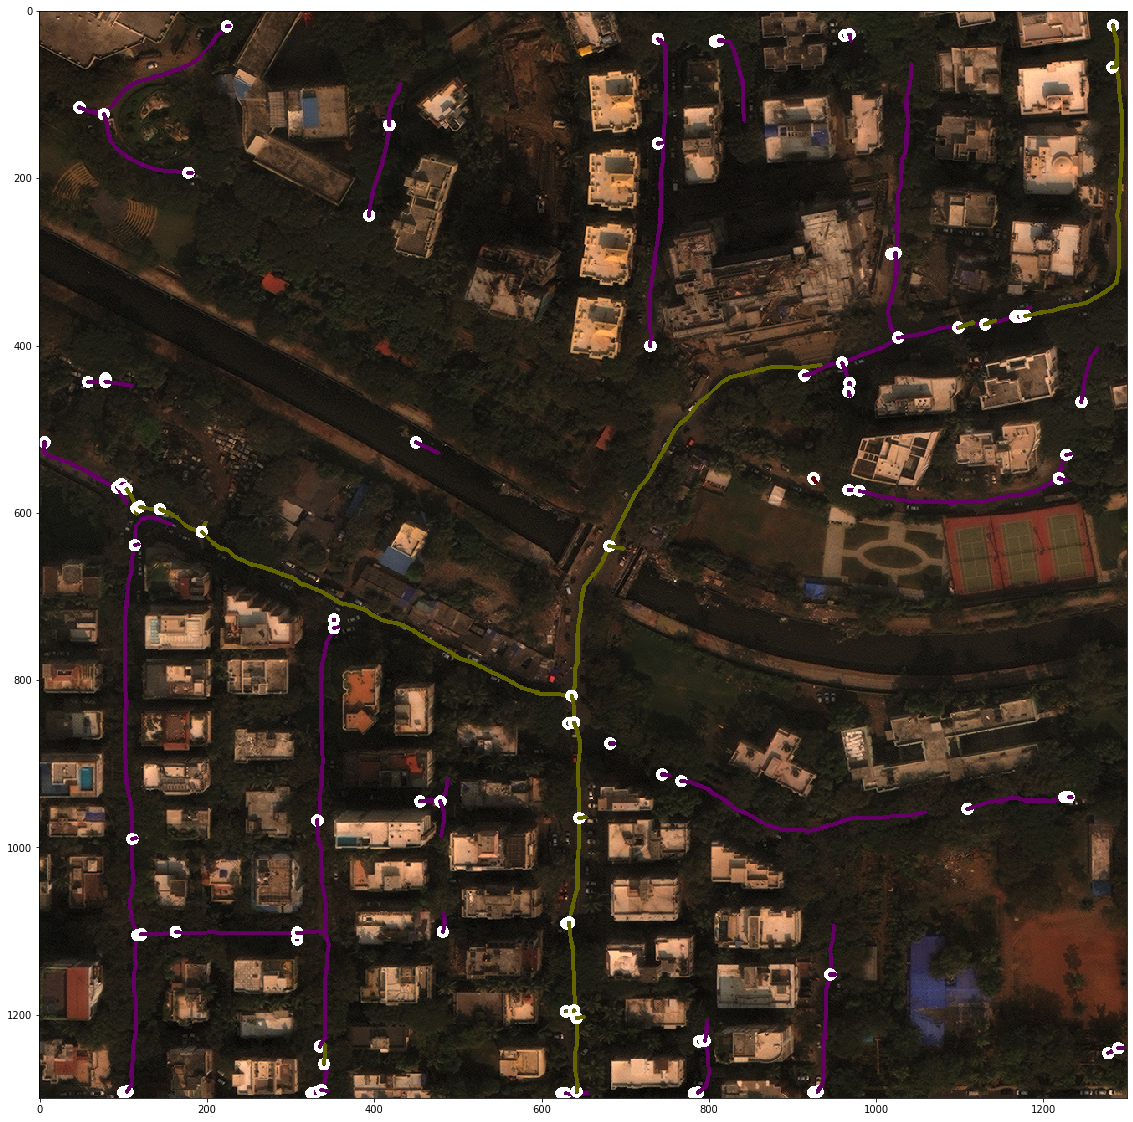

In [20]:
### lets view the image with speedwise road mask with my custom viewer cmd line tool ###
### the tool reads the input csv and plots the linestring over input image and saves img file as temp.png
os.system('python viewer.py {} {}'.format(csv_path[0],path))
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(20,20),sharey=True)
ax.imshow(plt.imread('temp.png'))
plt.show()

In [0]:
### combine a dir full of csv of extracted roads of all cities
CSV_DIR='/content/csv/dir_csv'
combine_submissions(CSV_DIR)